In [1]:
%load_ext autoreload
%autoreload 2

# Generate tree anchor name, pos record name, neg record name triplets to train the cross encoder

Use the training data to generate (anchor, pos, pos_score, neg, neg_score) triplets.

We decided to use tree_name_min_freq=1000 going forward

In [2]:
from collections import Counter, defaultdict
import random

import pandas as pd
from tqdm.auto import tqdm

from nama.data.filesystem import download_file_from_s3, save_file
from nama.data.utils import load_dataset

In [20]:
# Config

# TODO do for given and surname
given_surname = "given"
# given_surname = "surname"

tree_name_min_freq = 1000
record_name_min_freq = 200
pos_threshold = 0.5
max_triplets_per_tree_name = 2000

score_smoothing=20
score_multiplier=0.38

train_path = f"s3://fs-nama-data/2024/familysearch-names/processed/tree-hr-{given_surname}-train.csv.gz"

triplets_path=f"s3://fs-nama-data/2024/familysearch-names/processed/tree-hr-{given_surname}-triplets-{tree_name_min_freq}.csv.gz"

## Load data

In [6]:
# load train data
path = download_file_from_s3(train_path) if train_path.startswith("s3://") else train_path
tree_names_train, attached_names_train, record_names_train = load_dataset(path)

In [7]:
print("tree_names_train", len(tree_names_train))
print("attached_names_train", sum(len(attaches) for attaches in attached_names_train))
print("total pairs", sum(freq for attachments in attached_names_train for _, freq in attachments))
print("record_names_train", len(record_names_train))
print("total names", len(set(tree_names_train).union(set(record_names_train))))

tree_names_train 581934
attached_names_train 3790287
total pairs 1072113643
record_names_train 791151
total names 836285


## Generate triplets

In [8]:
total_tree_occurs = Counter()
total_record_occurs = Counter()
for tree_name, attachments in tqdm(zip(tree_names_train, attached_names_train), mininterval=1.0):
    # attachments is a list of (record name, frequency)
    for attachment in attachments:
        # include frequency even if a name goes to itself, 
        # because if a name usually goes to itself, we want its vector
        # to not be that close to another vector
        total_tree_occurs[tree_name] += attachment[1]
        total_record_occurs[attachment[0]] += attachment[1]

0it [00:00, ?it/s]

In [9]:
tree_names_train_ixs = {}
for ix, tree_name in enumerate(tree_names_train):
    tree_names_train_ixs[tree_name] = ix

In [10]:
def _score(tree_name, record_name):
    tree_ix = tree_names_train_ixs[tree_name]
    freq = 0
    for name_freq in attached_names_train[tree_ix]:
        if name_freq[0] == record_name:
            freq = name_freq[1]
            break
    total_tree_occur = total_tree_occurs[tree_name]
    tree_co_occur_ratio = freq / total_tree_occur
    total_record_occur = total_record_occurs[record_name]
    record_co_occur_ratio = freq / total_record_occur
    return freq, tree_co_occur_ratio, record_co_occur_ratio

def sample_scores(tree_name, pos, pos_score, neg, neg_score):
    for name, score in [(pos, pos_score), (neg, neg_score)]:
        bucket = int(score * 10)
        if random.random() < 0.001 and len(score_buckets[bucket]) < 40:
            freq, tree_co_occur_ratio, record_co_occur_ratio = _score(tree_name, name)
            score_buckets[bucket].append({
                'tree_name': tree_name, 
                'record_name': name, 
                'score': score, 
                'tree_co_occur_ratio': tree_co_occur_ratio,
                'record_co_occur_ratio': record_co_occur_ratio,
                'freq': freq,
            })

In [11]:
# smooth rare names, increase all scores by a multiplier
# we want nearly every attachment to score at least 0.4
def score(tree_name, record_name, smoothing=score_smoothing, multiplier=score_multiplier):
    tree_ix = tree_names_train_ixs[tree_name]
    freq = 0
    for name_freq in attached_names_train[tree_ix]:
        if name_freq[0] == record_name:
            freq = name_freq[1]
            break
    total_tree_occur = total_tree_occurs[tree_name]
    tree_co_occur_ratio = (freq + smoothing) / (total_tree_occur + smoothing)
    total_record_occur = total_record_occurs[record_name]
    record_co_occur_ratio = (freq + smoothing) / (total_record_occur + smoothing)
    max_score = max(tree_co_occur_ratio, record_co_occur_ratio)
    return max_score + multiplier * (1.0 - max_score)

In [12]:
score_buckets = defaultdict(list)

total_record_candidates = 0
total_tree_names = 0
triplets = []
for tree_name, attachments in tqdm(zip(tree_names_train, attached_names_train)):
    if total_tree_occurs[tree_name] < tree_name_min_freq:
        continue
    record_candidates = [name_freq for name_freq in attachments \
                         if total_record_occurs[name_freq[0]] >= record_name_min_freq]
    pairs = set()
    for pos_candidate in record_candidates:
        pos_name = pos_candidate[0]
        if pos_name == tree_name:
            continue
        for neg_candidate in record_candidates:
            neg_name = neg_candidate[0]
            if neg_name == tree_name:
                continue
            if pos_name == neg_name:
                continue
            if f"{pos_name},{neg_name}" in pairs \
            or f"{neg_name},{pos_name}" in pairs:
                continue
            pos_score = score(tree_name, pos_name, smoothing=score_smoothing, multiplier=score_multiplier)
            neg_score = score(tree_name, neg_name, smoothing=score_smoothing, multiplier=score_multiplier)
            if max(pos_score, neg_score) < pos_threshold:
                continue
            if pos_score < neg_score:
                pos_name, pos_score, neg_name, neg_score = neg_name, neg_score, pos_name, pos_score
            pairs.add(f"{pos_name},{neg_name}")
            triplets.append({
                'anchor': tree_name, 
                'positive': pos_name, 
                'positive_score': pos_score, 
                'negative': neg_name, 
                'negative_score': neg_score
            })
            sample_scores(tree_name, pos_name, pos_score, neg_name, neg_score)
            if len(pairs) == max_triplets_per_tree_name:
                break
        if len(pairs) == max_triplets_per_tree_name:
            break
    total_record_candidates += len(record_candidates)
    total_tree_names += 1
print('tree names', total_tree_names)
print('total record candidates for all tree names', total_record_candidates)
print('avg record candidates per tree name', total_record_candidates / total_tree_names)
print('total triplets', len(triplets))

0it [00:00, ?it/s]

tree names 19588
total record candidates for all tree names 670211
avg record candidates per tree name 34.215386971615274
total triplets 3289279


### positive scores

<Axes: >

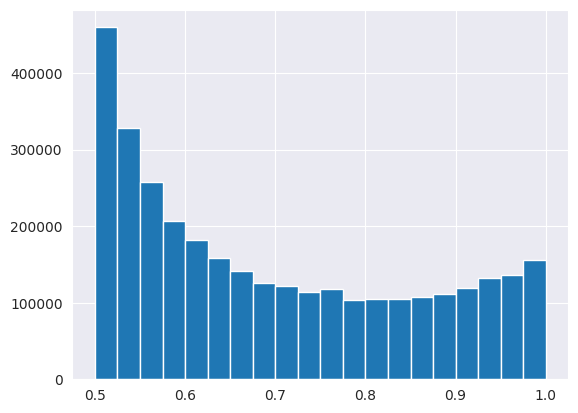

In [13]:
df = pd.DataFrame(triplets)
df['positive_score'].hist(bins=20)

### negative scores

<Axes: >

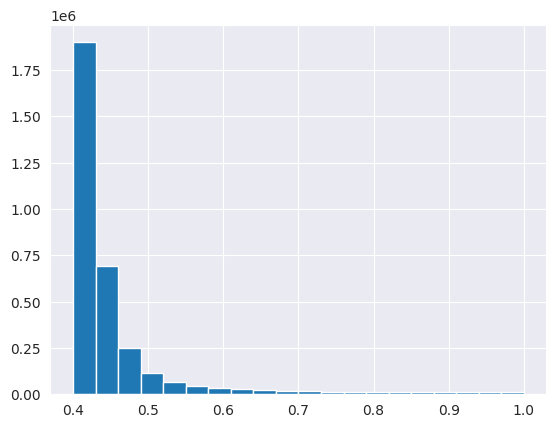

In [14]:
df['negative_score'].hist(bins=20)

In [15]:
triplets[::10000]

[{'anchor': 'aafje',
  'positive': 'aafien',
  'positive_score': 0.5107061503416856,
  'negative': 'aaffien',
  'negative_score': 0.4844537815126051},
 {'anchor': 'abraham',
  'positive': 'aberaham',
  'positive_score': 0.9638668779714739,
  'negative': 'adrah',
  'negative_score': 0.45972850678733035},
 {'anchor': 'addie',
  'positive': 'addin',
  'positive_score': 0.582905982905983,
  'negative': 'aggie',
  'negative_score': 0.41053573425791295},
 {'anchor': 'adele',
  'positive': 'adale',
  'positive_score': 0.6943992340832934,
  'negative': 'addle',
  'negative_score': 0.6428915662650603},
 {'anchor': 'adella',
  'positive': 'adilla',
  'positive_score': 0.6502673796791444,
  'negative': 'addelle',
  'negative_score': 0.4574162679425837},
 {'anchor': 'adriana',
  'positive': 'adrijana',
  'positive_score': 0.9467889908256881,
  'negative': 'andreina',
  'negative_score': 0.4554140127388535},
 {'anchor': 'agueda',
  'positive': 'aguada',
  'positive_score': 0.9656565656565657,
  'ne

### sample scores

In [16]:
bucket = 4
pd.DataFrame(score_buckets[bucket])

,tree_name,record_name,score,tree_co_occur_ratio,record_co_occur_ratio,freq
0,aaron,arnon,0.455556,0.000176,0.072383,65
1,abdona,aldena,0.406714,0.001028,0.000994,2
2,abel,sibel,0.404932,0.000053,0.001909,6
3,abelone,melene,0.431894,0.000912,0.020619,12
4,abigal,abigale,0.415369,0.015305,0.021637,106
5,abram,abraha,0.436750,0.000261,0.037179,29
6,ada,aldia,0.406397,0.000003,0.001793,4
7,ada,eda,0.448064,0.003215,0.079780,4491
8,adalbert,alberth,0.417180,0.001909,0.021629,60
9,adaline,adalaide,0.411007,0.001490,0.017249,309


## Save triplets

In [17]:
random.shuffle(triplets)

In [18]:
df = pd.DataFrame(triplets)

In [21]:
save_file(triplets_path,
          lambda local_out_path : df.to_csv(local_out_path, index=False))

In [22]:
triplets_path

's3://fs-nama-data/2024/familysearch-names/processed/tree-hr-given-triplets-1000.csv.gz'